In [1]:
!pip install -r requirements.txt -q
!sudo apt-get update -q && sudo apt-get install -y libgl1 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires onnxruntime<2,>=1.15.0, which is not installed.
autogluon-multimodal 1.4.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires numpy<=2.0.1, but you have numpy 2.2.6 which is incompatible.
amazon-sagemaker-sql-magic 0.1.4 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
autogluon-multimodal 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.55.2 which is incompatible.
autogluon-timeseries 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.55.2 which is incompatible.
gluonts 0.16.2 requires numpy<2.2,>=1.16, but you have numpy 2.2.6 which is incompatible.
langchain-aws 0.2.19 requires boto3>=1.37.24, but you hav

In [1]:
#manipolazione dati 
import cv2
import numpy as np 
import torch
import torchvision.transforms as transforms



#sistema
import sys
import os
import gc
import time

#displaying a video 
from IPython.display import HTML,display, clear_output

#loading mat
from scipy.io import loadmat
import mat73


#visualizzazione
import matplotlib.pyplot as plt
from PIL import Image

#utility 
import re
from base64 import b64encode
from src.utils import utility_fun as uf


In [2]:
path_env_dict=uf.get_path_env()
RAW_VIDEO= path_env_dict['RAW_VIDEO']
RAW_FACIAL_MARK_PATH = path_env_dict['RAW_FACIAL_MARK_PATH']
FACIAL_MARKS_UNIMI = path_env_dict["FACIAL_MARKS_UNIMI"]
# un json per video contenent i punti di fixation di output + info sul video. Verranno utilizzati insieme a quelli di input per i dataset
RAW_FIX_DURATION_PATH = path_env_dict["RAW_FIX_DURATION_PATH"]
GAZE_MODEL_INPUT_EXAMPLE = path_env_dict["GAZE_INPUT_EXAMPLE_PATH"]
#un json per video contenete i punti di fixation stimati usando modello di gaze. Il json conteien anche i pesi e altre informazioni da usare
GAZE_INPUT_POINT_DATA_PATH = path_env_dict["GAZE_INPUT_POINT_DATA_PATH"]
GAUSSIAN_ISO_INPUT_DATA_PATH=path_env_dict["GAUSSIAN_ISO_INPUT_DATA_PATH"]
GAUSSIAN_COV_INPUT_DATA_PATH=path_env_dict["GAUSSIAN_COV_INPUT_DATA_PATH"]
GAUSSIAN_ISOk_INPUT_DATA_PATH =path_env_dict["GAUSSIAN_ISOk_INPUT_DATA_PATH"] 
GAUSSIAN_COVk_INPUT_DATA_PATH = path_env_dict["GAUSSIAN_COVk_INPUT_DATA_PATH"]
#produciamo anche le stesse mappe con moltiplicare di incertezza sulla sigma sapendo che z975/z90=1.5 circa


#altre variabili di ambiente
DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE',DEVICE)

DEVICE cpu


In [3]:
def load_gazemodel():  
    sys.path.append('./models/gaze360/code/')
    from model import GazeLSTM
    model = GazeLSTM()
    model = torch.nn.DataParallel(model).to(DEVICE)#.cuda()
    #model.cuda()
    checkpoint = torch.load('./models/gaze360/gaze360_model.pth.tar',map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

## GOAL: costruzione mappe a partire dai dati di gaze per ogni frame e video 
### step: 
    1) costruzione json di facial mark per accesso facilitato ai dati  
    2) test modello gaze estimation 
    3) definizione specifiche (dimensione bound box rispetto ai facial marks su cui applicare modello, conversione coordinate, utilizzo deviazione standard) 
    4) applicazione modello e produzione json per video. Ogni json conterrà la lista di punti di gaze (una tripla (x,y,std) per individuo nel frame). Inoltre sempre per individuo conviene memorizzare delle info da usare poi per stimare pesi o avere info in più: 
    a) gz per capire quanto sguardo è orientato rispetto asse z della camera (es. gz vicino -1 guarda verso la camera,se vicino a 0 è tangente al piano)
    b) peso ottenuto in base alla dimesnione della faccia rispetto alla dimesnione di faccia più grande nell'immagine
    c) peso ottenuto in base alla distanza dal centro. Vogliamo dare più peso a chi si trova a sinistra Quindi C-centro_crop_frame/crop_occhi
    d)centro in mezzo occhi (x,y)
    5) costruzione mappe gaussiane (similmente a come fatto per output) 

## 1) costruzione json di facial mark per accesso facilitato ai dati  

### test facial mark su frame 

In [8]:
VIDEO_ID = 1
if str(VIDEO_ID).zfill(3)+'.mp4' in os.listdir(os.path.join(RAW_VIDEO)):
    print('\n**************')
    print('VIDEO ID=>',VIDEO_ID)
    mat_facial_marks,format_mat = uf.load_mat_data(os.path.join(FACIAL_MARKS_UNIMI,f'final{VIDEO_ID}.mat')) 
    frame_count,max_faces_cnt=uf.get_facial_mark_info_from_raw_data(facial_raw=mat_facial_marks['final'],format_mat=format_mat)
    print('frame count ==>',frame_count, 'max_facs_cnt ==>',max_faces_cnt)
    frame_id=0 
    aframe=uf.read_specific_frame(video_path=os.path.join(RAW_VIDEO,str(VIDEO_ID).zfill(3)+'.mp4'),frame_idx=frame_id) 
    #print(type(aframe),aframe.shape)
    if aframe is not None:
        #es frame shape (720, 1280, 3) =[altezza x larghezza x ch]
        height_f = aframe.shape[0] 
        width_f = aframe.shape[1] 
        print('frame shape',aframe.shape)
        #show_frame_in_notebook(aframe)
        frame_count,max_faces_cnt=uf.get_facial_mark_info_from_raw_data(facial_raw=mat_facial_marks['final'],format_mat=format_mat)
        for face_idx in range(max_faces_cnt):
            try:
                fm_list=uf.get_facial_mark_from_raw_data(facial_raw=mat_facial_marks['final'],format_mat=format_mat,frame_id=frame_id,face_id=face_idx).tolist()
                aframe = uf.draw_landmarks(frame=aframe, landmarks=fm_list, style='x')
            except Exception as e:  
                continue


**************
VIDEO ID=> 1
****reading new mat data
cannot read using loadmat fun Please use HDF reader for matlab v7.3 files, e.g. h5py
trying to use mat73...
reading mat success!********
frame count ==> 600 max_facs_cnt ==> 2
frame shape (720, 1280, 3)


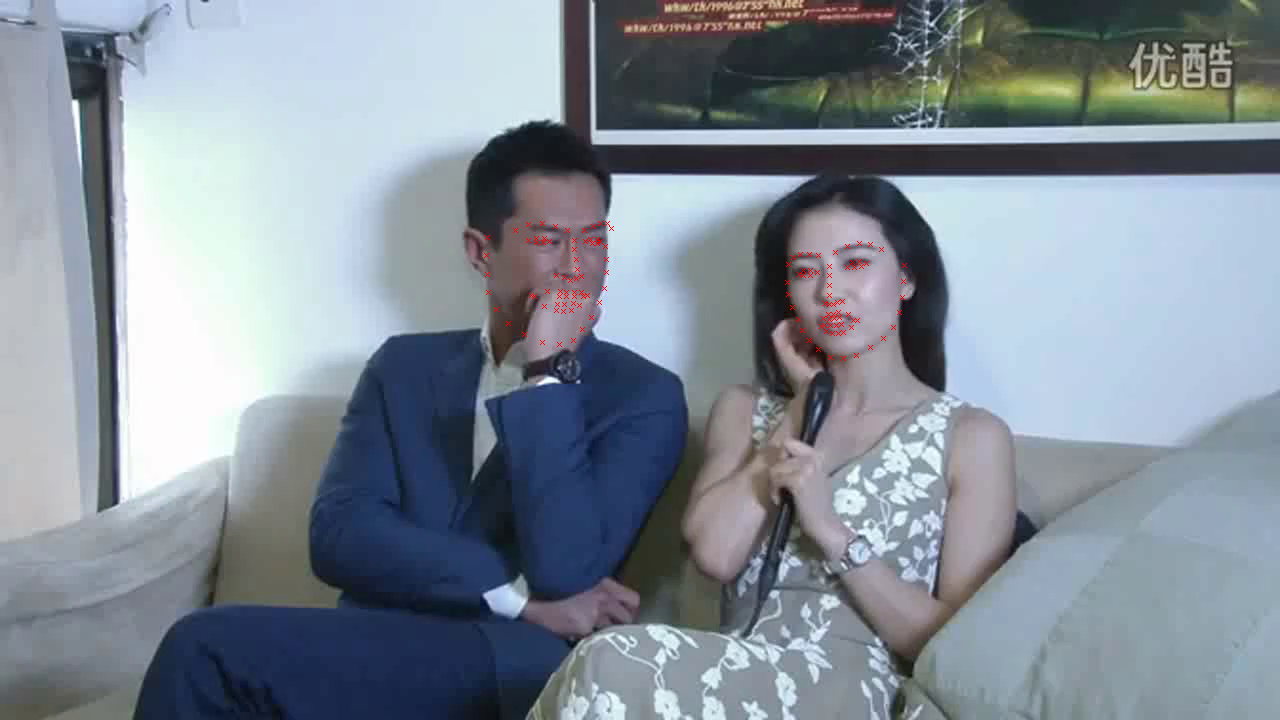

In [9]:
uf.show_frame_in_notebook(aframe)

### costruzione dati json facial marks
#### nota: partiamo dai dati di fixation poichè vogliamo assicurare di lavorare solo sul'intersezione tra video input e output per la creazione successiva del dataset

In [27]:
for fix_data_name in os.listdir(RAW_FIX_DURATION_PATH): 
    if fix_data_name.endswith('.json'):  
        fix_dur_js=uf.read_json(path=os.path.join(RAW_FIX_DURATION_PATH,fix_data_name))
        VIDEO_ID=fix_dur_js['VIDEO_ID']
        FRAME_SHAPE=fix_dur_js['FRAME_HW']
        FRAME_COUNT=fix_dur_js['FRAME_CNT']
        #carica facial mark unimi data 
        mat_facial_marks,format_mat = uf.load_mat_data(os.path.join(FACIAL_MARKS_UNIMI,f'final{VIDEO_ID}.mat')) 
        frame_count,max_faces_cnt=uf.get_facial_mark_info_from_raw_data(facial_raw=mat_facial_marks['final'],format_mat=format_mat)
        #definisci json atteso 
        custom_facial_mark_data={
            'VIDEO_ID':VIDEO_ID, 'FRAME_HW': FRAME_SHAPE,
            'FACES_CNT':max_faces_cnt,'FRAME_CNT': FRAME_COUNT,  
            # facial data contiene come chiave l'id della faccia e come valore è una lista di liste: [frame x markpoints_len x 2]quindi facial_data[0][2] denota la lista
            #dei punti facciali rispetto alla faccia con id=0 e presenti nel frame di id=2 
            'FACIAL_DATA' : {}}
        
        for face_idx in range(max_faces_cnt):
            mark_per_frame_data = [[]]*FRAME_COUNT 
            for frame_idx in range(FRAME_COUNT):
                mark_per_frame_data[frame_idx]=[]
                try:
                    fm_list=uf.get_facial_mark_from_raw_data(facial_raw=mat_facial_marks['final'],format_mat=format_mat,frame_id=frame_idx,face_id=face_idx).tolist()
                    mark_per_frame_data[frame_idx]=fm_list
                except Exception as e:  
                    continue
            custom_facial_mark_data['FACIAL_DATA'][str(face_idx)]=mark_per_frame_data
        #salva come json
        uf.write_json(data=custom_facial_mark_data,path=os.path.join(RAW_FACIAL_MARK_PATH,f'{VIDEO_ID}.json'))

****reading new mat data
reading mat success!********
****reading new mat data
cannot read using loadmat fun Please use HDF reader for matlab v7.3 files, e.g. h5py
trying to use mat73...
reading mat success!********
****reading new mat data
cannot read using loadmat fun Please use HDF reader for matlab v7.3 files, e.g. h5py
trying to use mat73...
reading mat success!********
****reading new mat data
cannot read using loadmat fun Please use HDF reader for matlab v7.3 files, e.g. h5py
trying to use mat73...
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
cannot read using loadmat fun Please use HDF reader for matlab v7.3 files, e.g. h5py
trying to use mat73...
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
can

### testing custom facial marks

In [5]:
#(video id,frame) 
#(3,4) 
#(4,4)

In [6]:
bound_boxes_stat={'h':[],'w':[],'hw':[]}

In [265]:
VIDEO_ID =11
FRAME_ID=0

if str(VIDEO_ID).zfill(3)+'.mp4' in os.listdir(os.path.join(RAW_VIDEO)):
    print('\n**************')
    print('VIDEO ID=>',VIDEO_ID)
    custom_facial_mark_data=uf.read_json(path=os.path.join(RAW_FACIAL_MARK_PATH,f'{VIDEO_ID}.json'))
    print('keys=>',custom_facial_mark_data.keys())
    VIDEO_ID_fm = custom_facial_mark_data['VIDEO_ID']
    FRAME_HW_fm = custom_facial_mark_data['FRAME_HW']
    FACES_CNT_fm = custom_facial_mark_data['FACES_CNT']
    FACIAL_DATA_fm=custom_facial_mark_data['FACIAL_DATA']
    print('***info facial mark data:\n', 'VIDEO_ID=>',VIDEO_ID_fm,'FRAME_HW_fm=>',FRAME_HW_fm,'FACES_CNT_fm=>',FACES_CNT_fm)
    aframe=uf.read_specific_frame(video_path=os.path.join(RAW_VIDEO,str(VIDEO_ID).zfill(3)+'.mp4'),frame_idx=FRAME_ID) 
    #salva frame originale 
    cv2.imwrite(os.path.join(GAZE_MODEL_INPUT_EXAMPLE,f"frame_video_{VIDEO_ID}_frame_{FRAME_ID}.png"), aframe)
    for face_id in range(FACES_CNT_fm):  
        fm_list_wrt_face_frame= FACIAL_DATA_fm[str(face_id)][FRAME_ID] 
        #se ci sono 68 punti ci sono cira 12 punti corrispondenti ad entrambi gli occhi
        eys_idx_pos=(0,len(fm_list_wrt_face_frame))
        if len(fm_list_wrt_face_frame)==39:
            #se ci sono 39 punti 
            eyes_idx_pos = (5,14) #circa 9 punti 
        elif  len(fm_list_wrt_face_frame)>39:
            eyes_idx_pos = (36,48)
        print('====>',len(fm_list_wrt_face_frame))
        #print('len land marks==>',len(fm_list_wrt_face_frame))


        #bounding box occhi 
        eyes_x,eyes_y, eyes_w,eyes_h = uf.get_face_bounding_box(landmarks=fm_list_wrt_face_frame[eyes_idx_pos[0]:eyes_idx_pos[1]],pad_w_r=0,pad_h_r=0)
        cv2.rectangle(aframe, (int(eyes_x),int(eyes_y)), (int(eyes_x+eyes_w), int(eyes_y+eyes_h)), color=(0, 0, 255), thickness=2)
        #bounding box faccia
        x, y, w, h = uf.get_face_bounding_box(landmarks=fm_list_wrt_face_frame,pad_w_r=0.5,pad_h_r=0.5)
        print('bounding box faccia (x,y,x+w,y+h)==>',x,y,x+w,y+h)
        x, y, w, h= uf.clamp_rect_to_frame(x, y, w, h, frame_shape=aframe.shape)
        print('POST CLAMP: bounding box faccia (x,y,x+w,y+h)==>',x,y,x+w,y+h)
        bound_boxes_stat['h'].append(h) 
        bound_boxes_stat['w'].append(w) 
        bound_boxes_stat['hw'].append(h*w)
        cv2.rectangle(aframe, (int(x),int(y)), (int(x+w), int(y+h)), color=(0, 255, 0), thickness=2)
        print('rectangle coordinate=>(x,y, x+w, y+h)=>',(int(x),int(y)), int(x+w), int(y+h))
        # Croppa regione faccia
        print('aframe shape=>',aframe.shape)
        cropped = aframe[int(y):int(y+h), int(x):int(x+w)]
        #print('cropped=>',cropped.shape)
        #salva crop
        cv2.imwrite(os.path.join(GAZE_MODEL_INPUT_EXAMPLE,f"cropped_video_{VIDEO_ID}_face_{face_id}_frame_{FRAME_ID}.png"), cropped)
        #disegna landmark
        aframe = uf.draw_landmarks(frame=aframe, landmarks=fm_list_wrt_face_frame[eyes_idx_pos[0]:eyes_idx_pos[1]], style='x')


**************
VIDEO ID=> 11
keys=> dict_keys(['VIDEO_ID', 'FRAME_HW', 'FACES_CNT', 'FRAME_CNT', 'FACIAL_DATA'])
***info facial mark data:
 VIDEO_ID=> 11 FRAME_HW_fm=> [720, 1280] FACES_CNT_fm=> 3
====> 39
bounding box faccia (x,y,x+w,y+h)==> 783.0647051998883 190.52462667588404 971.9595695758647 382.8374793213029
POST CLAMP: bounding box faccia (x,y,x+w,y+h)==> 783.0647051998883 190.52462667588404 971.9595695758647 382.8374793213029
rectangle coordinate=>(x,y, x+w, y+h)=> (783, 190) 971 382
aframe shape=> (720, 1280, 3)
====> 68
bounding box faccia (x,y,x+w,y+h)==> 527.9941169245437 180.88896066570712 744.3861202161047 397.70824899931165
POST CLAMP: bounding box faccia (x,y,x+w,y+h)==> 527.9941169245437 180.88896066570712 744.3861202161047 397.70824899931165
rectangle coordinate=>(x,y, x+w, y+h)=> (527, 180) 744 397
aframe shape=> (720, 1280, 3)
====> 39
bounding box faccia (x,y,x+w,y+h)==> 106.44642727981329 272.8388155863686 311.5990953319515 422.6626237363749
POST CLAMP: bounding 

In [266]:
print('bounding box stat. median w:',np.median(bound_boxes_stat['w']),' median h:', np.median(bound_boxes_stat['h']),'sqrt(max hw):',np.sqrt(np.max(bound_boxes_stat['hw'])))

bounding box stat. median w: 197.02376621405733  median h: 183.02042736317978 sqrt(max hw): 244.78969350642328


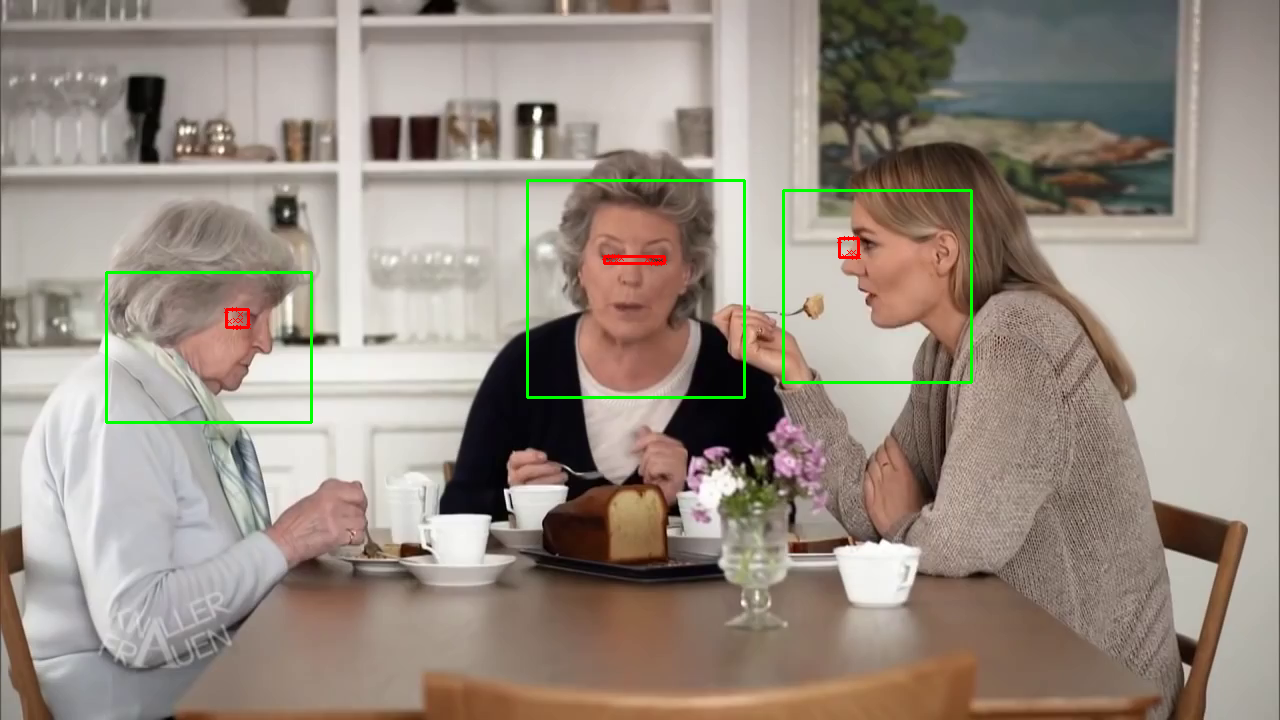

In [267]:
uf.show_frame_in_notebook(aframe)

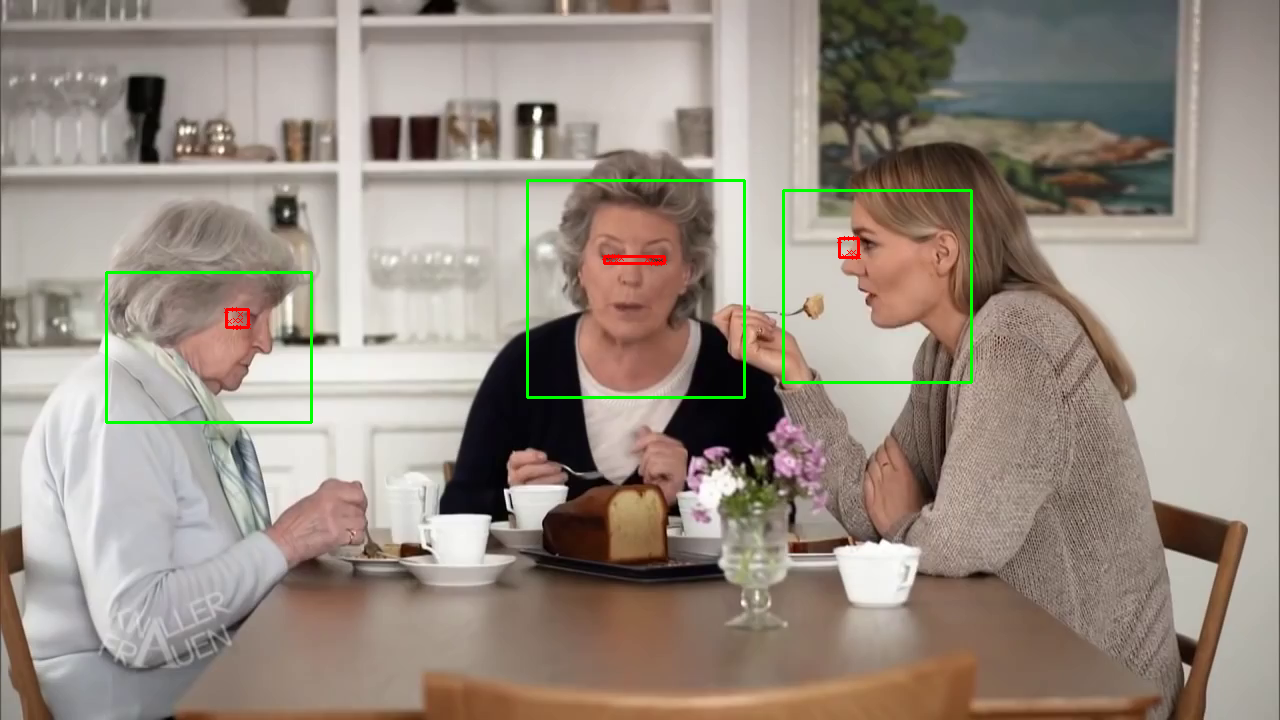

In [268]:
uf.show_frame_in_notebook(aframe)

### finding eyes marks

In [133]:
all_landmark_len={}
for landmark_data_name in os.listdir(RAW_FACIAL_MARK_PATH): 
    custom_facial_mark_data=uf.read_json(path=os.path.join(RAW_FACIAL_MARK_PATH,landmark_data_name))
    #print('keys=>',custom_facial_mark_data.keys())
    VIDEO_ID_fm = custom_facial_mark_data['VIDEO_ID']
    FRAME_HW_fm = custom_facial_mark_data['FRAME_HW']
    FACES_CNT_fm = custom_facial_mark_data['FACES_CNT']
    FACIAL_DATA_fm=custom_facial_mark_data['FACIAL_DATA']
    FRAME_CNT_fm = custom_facial_mark_data['FRAME_CNT']
    
    for frame_id in range(FRAME_CNT_fm): 
        for face_id in range(FACES_CNT_fm): 
            fm_list_wrt_face_frame= FACIAL_DATA_fm[str(face_id)][frame_id] 
            len_landmark_l=len(fm_list_wrt_face_frame)
            if len_landmark_l not in all_landmark_len:  
                all_landmark_len[len_landmark_l]=[] 
            if VIDEO_ID_fm not in all_landmark_len[len_landmark_l]:
                all_landmark_len[len_landmark_l].append(VIDEO_ID_fm)

KeyboardInterrupt: 

In [ ]:
#print('facial mark lengths===>',all_landmark_len.keys()) 
for fm_len in all_landmark_len.keys(): 
    video_ids = np.unique(all_landmark_len[fm_len])
    print('**************\n')
    print(f'there are {video_ids.shape[0]}) with {fm_len} landmark. That is:\n {sorted(all_landmark_len[fm_len])}\n')

## 2) test modello gaze estimation
    a) test modelllo su esempi di crop di visi
    b) plot punto di gaze sia nel frame croppato che nel frame originale (full frame)

In [ ]:
!ls
!git clone https://github.com/erkil1452/gaze360 models/gaze360 
!wget -P models/gaze360 http://gaze360.csail.mit.edu/files/gaze360_model.pth.tar

###  test loading gaze model

In [134]:
model=load_gazemodel()

### testa applicazione modello su frame di esempio

In [322]:
#nb: gaze360 richiede 7 frame di input (3 + frame target + 3] x 3 canali x dimensione frame per cnn
input_image = torch.zeros(7,3,224,224)
count = 0
#VIDEO_ID = 4
FACE_ID=2
#FRAME_ID=3
print('VIDEO ID==>',VIDEO_ID,'FRame id=>',FRAME_ID,'FACE_ID',FACE_ID)
cropped_img_name=f'cropped_video_{VIDEO_ID}_face_{FACE_ID}_frame_{FRAME_ID}.png'
crop_frame = cv2.imread(os.path.join(GAZE_MODEL_INPUT_EXAMPLE,cropped_img_name))
frame_img_name=f'frame_video_{VIDEO_ID}_frame_{FRAME_ID}.png'
full_frame = cv2.imread(os.path.join(GAZE_MODEL_INPUT_EXAMPLE,frame_img_name))
print('frame img=>',frame_img_name)

custom_facial_mark_data=uf.read_json(path=os.path.join(RAW_FACIAL_MARK_PATH,f'{VIDEO_ID}.json'))
FACIAL_DATA_fm=custom_facial_mark_data['FACIAL_DATA']
fm_list_wrt_face_frame= FACIAL_DATA_fm[str(FACE_ID)][FRAME_ID] 
#se ci sono 68 punti ci sono cira 12 punti corrispondenti ad entrambi gli occhi
eys_idx_pos=(0,len(fm_list_wrt_face_frame))
if len(fm_list_wrt_face_frame)==39:
    #se ci sono 39 punti 
    eyes_idx_pos = (5,14) #circa 9 punti 
elif  len(fm_list_wrt_face_frame)>39:
    eyes_idx_pos = (36,48)
aframe=uf.read_specific_frame(video_path=os.path.join(RAW_VIDEO,str(VIDEO_ID).zfill(3)+'.mp4'),frame_idx=FRAME_ID) 
#bounding box occhi 
eyes_x,eyes_y, eyes_w,eyes_h = uf.get_face_bounding_box(landmarks=fm_list_wrt_face_frame[eyes_idx_pos[0]:eyes_idx_pos[1]],pad_w_r=0,pad_h_r=0)
#centro bb OCCHI 
eyes_middle_x = eyes_x + eyes_w/2 
eyes_middle_y = eyes_y + eyes_h/2 

#bounding box crop face
x, y, w, h = uf.get_face_bounding_box(landmarks=fm_list_wrt_face_frame,pad_w_r=0.5,pad_h_r=0.5)
x_face_crop, y_face_crop, w_face_crop, h_face_crop= uf.clamp_rect_to_frame(x, y, w, h, frame_shape=aframe.shape)

#disegna bb occhi 
cv2.rectangle(aframe, (int(eyes_x),int(eyes_y)), (int(eyes_x+eyes_w), int(eyes_y+eyes_h)), color=(0, 0, 255), thickness=2)
#disegna bb faccia 
cv2.rectangle(aframe, (int(x_face_crop),int(y_face_crop)), (int(x_face_crop+w_face_crop), int(y_face_crop+h_face_crop)), color=(0, 255, 0), thickness=2)
#disegna CENTRO OCCHI 
cv2.circle(aframe, (int(eyes_middle_x), int(eyes_middle_y)), radius=3, color=(0, 0, 255), thickness=-1)  
#per convertire in immagine PIL vogliamo RGB and no BGR (default per cv2)
rgb_frame = cv2.cvtColor(crop_frame, cv2.COLOR_BGR2RGB)
image_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

VIDEO ID==> 11 FRame id=> 0 FACE_ID 2
frame img=> frame_video_11_frame_0.png


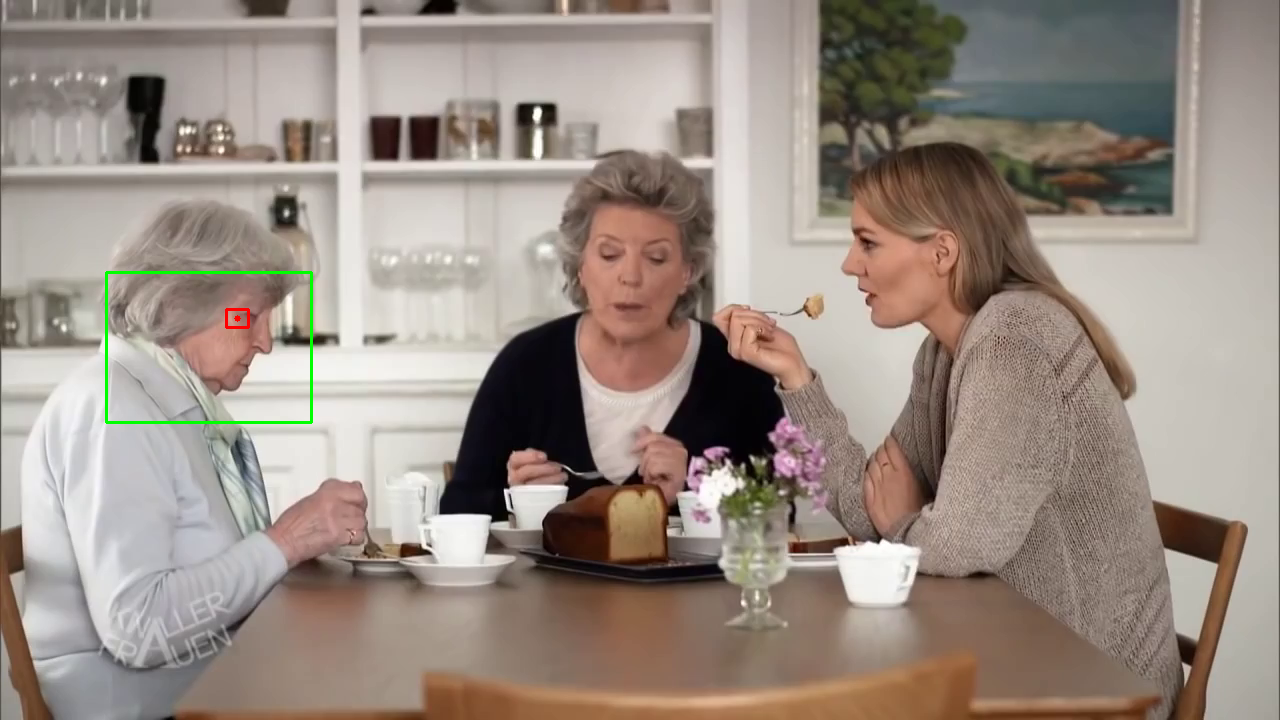

In [323]:
uf.show_frame_in_notebook(aframe)

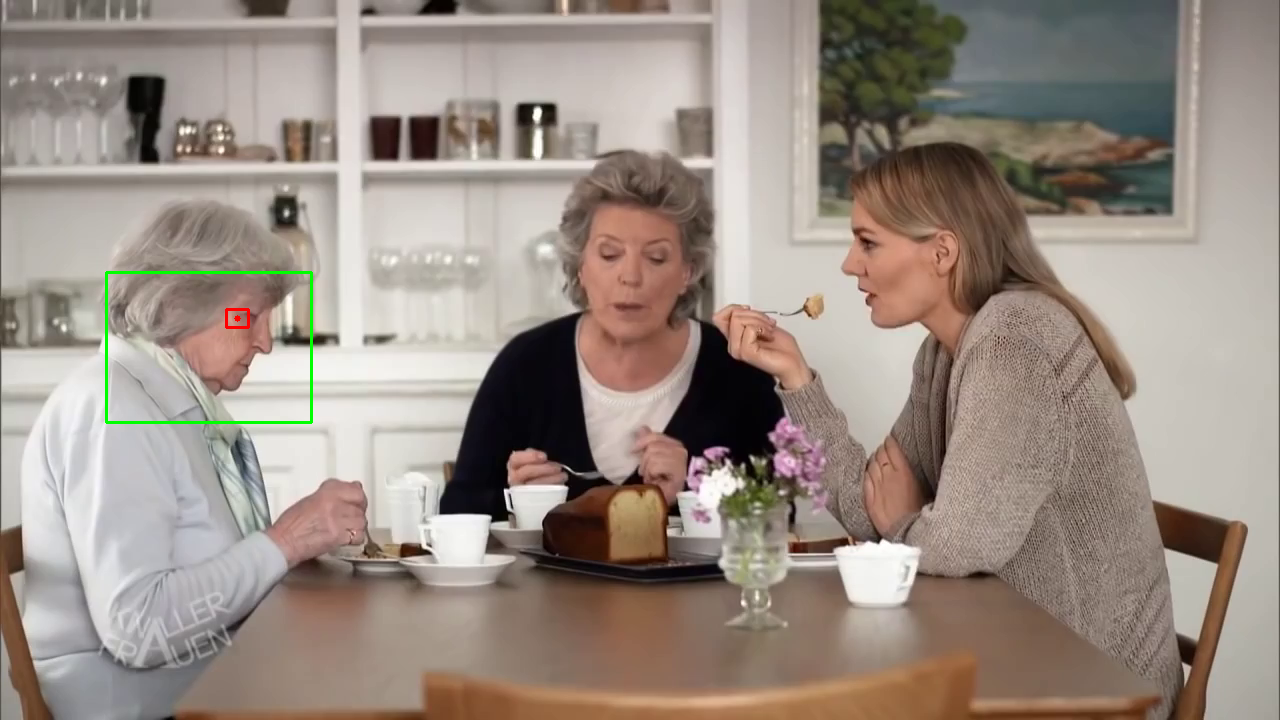

In [324]:
uf.show_frame_in_notebook(aframe)

In [325]:
#per effettuare il resize bisogna convertire in PIL
rgb_pil_frame = Image.fromarray(rgb_frame,'RGB')

/tmp/ipykernel_1269/463246790.py:2: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  rgb_pil_frame = Image.fromarray(rgb_frame,'RGB')


In [326]:
for count in range(7):
    input_image[count,:,:,:] = image_normalize(transforms.ToTensor()(transforms.Resize((224,224))(rgb_pil_frame)))

In [327]:
model_input_shape = (224,224)

In [328]:
output_gaze,output_std = model(input_image.view(1,7,3,224,224).to(DEVICE))

In [329]:
print('output gaze angles=>', output_gaze.detach(), 'output gaze std=>', output_std.detach())

output gaze angles=> tensor([[-0.6568, -0.6385]]) output gaze std=> tensor([[0.3531, 0.3531]])


In [330]:
angle_id = 0
angle_x_list=uf.sampling_angles_from_norm(angle=output_gaze.detach().numpy().reshape(-1)[angle_id],offset=output_std.detach().numpy().reshape(-1)[angle_id],n_sample=500)
angle_id = 1
angle_y_list=uf.sampling_angles_from_norm(angle=output_gaze.detach().numpy().reshape(-1)[angle_id],offset=output_std.detach().numpy().reshape(-1)[angle_id],n_sample=500)

In [331]:
gaze_vector = uf.spherical2cartesial(output_gaze).detach().numpy().reshape(-1)
print('estimated gazed coordinates',gaze_vector, 'norma=>',np.linalg.norm(gaze_vector))

estimated gazed coordinates [-0.49032414 -0.59595394 -0.63594115] norma=> 1.0


In [332]:
print('gx/gz==>',gaze_vector[0]/abs(gaze_vector[2]))

gx/gz==> -0.77102125


In [333]:
#CALCOLA origine occhi nel crop 
eyes_middle_y_in_crop = eyes_middle_y - y_face_crop
eyes_middle_x_in_crop = eyes_middle_x - x_face_crop
print('eyes (x,y) in crop=>',eyes_middle_x_in_crop,eyes_middle_y_in_crop)
#CALCOLA ORIGINE occhi nel crop ridimensionato 
x_in_crop_resized = eyes_middle_x_in_crop * (224 / w_face_crop)
y_in_crop_resized = eyes_middle_y_in_crop * (224 / h_face_crop)
print('w crop',w_face_crop,'h crop',h_face_crop)

eyes (x,y) in crop=> 130.94875649454997 45.685866865250716
w crop 205.1526680521382 h crop 149.8238081500063


In [334]:
cropped_to_resize_scale_factor =224/h_face_crop
cropped_to_resize_scale_factor*h_face_crop/2

112.0

In [335]:
def estimate_2d_gaze_endpoint_test(origin, gaze_vector, image_shape, scale_factor=1.5,face_size=None,prospective_eq=True):
    #stima 2d del vettore di gaze 
    #qui l'origine è il punto centrale tra occhi o eventualmente centro faccia
    x, y = origin
    gx, gy, gz = gaze_vector
    if gz>=0:
        print('********* GZ NOT VALID*******') 
        return None
    height, width = image_shape
    if face_size is None:
        face_size=height/4
    k =scale_factor*face_size  
    print('profondità k=>',k)
    #qui il segno va cambiato perchè ad es. se il soggetto guarda alla sua sx gaze3d.x<0 ma propriettato nell'immagine guarda a destra
    if prospective_eq==False:
        gz = 1
    end_x = x +k * (gx/(gz)) 
    #print('gx/gz=>',gx/gz)  
    #se gy>0 soggetto guarda su che significa lato immagine dovremo andare verso lo 0 quindi usare meno anche qui
    end_y = y + k * (gy/(gz)) 
    return (end_x, end_y,k)

In [336]:
kx =0 
ky = 0
origine_x= int(x_in_crop_resized)
origine_y= int(y_in_crop_resized)
print('origin(x,y)=>',(origine_x,origine_y))
#gli occhi in general saranno all'incirca la metà 224/2 ma in diversi casi può essere poco dopo o poco più consideriamo quindi 1/4. 
#e di questo 1/4 andremo a considerare 1/4 come distanza
depth_k  = (224/2)*0.5


#gli occhi saranno sempre all'incirca alla metà dell'immagine quindi circa 112 posso quindi considerà la metà della metà rimanente. Per essere più stretto posso ridurlo
#ancora (1/3)
gaze_x,gaze_y,k=estimate_2d_gaze_endpoint_test(origin=(origine_x,origine_y),face_size=depth_k, gaze_vector=gaze_vector, image_shape=model_input_shape, scale_factor=1,prospective_eq=True)

origin(x,y)=> (142, 68)
profondità k=> 56.0


In [337]:
print('gaze estimated=>',gaze_x,gaze_y)

gaze estimated=> 185.17719 120.47879


In [338]:
print('With false gaze estimated=>',gaze_x,gaze_y)

With false gaze estimated=> 185.17719 120.47879


In [339]:
gaze2d_points ={'x':[],'y':[]}
for angle_x,angle_y in zip(angle_x_list,angle_y_list): 
    gaze_vector_tmp=uf.spherical2cartesial(torch.FloatTensor([[angle_x,angle_y]])).detach().numpy().reshape(-1)
    gaze2d_x,gaze2d_y,k=estimate_2d_gaze_endpoint_test(origin=(origine_x,origine_y), gaze_vector=gaze_vector_tmp, image_shape=model_input_shape, scale_factor=1,prospective_eq=True)
    gaze2d_points['x'].append(gaze2d_x)
    gaze2d_points['y'].append(gaze2d_y)
#calcola deviazione per x e anche per y 
std_x = np.std(gaze2d_points['x'], ddof=1)
std_y = np.std(gaze2d_points['y'], ddof=1)
std_gauss_estimated= np.mean([std_x,std_y])
print(std_gauss_estimated,std_x**2,std_y**2)
points = np.array(list(zip(gaze2d_points['x'], gaze2d_points['y'])))
cov_matrix = np.cov(points.T).tolist()
print('cov matrix==>',cov_matrix)


profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0
profondità k=> 56.0


In [340]:
print('model input shape',model_input_shape,'crop frame=>',crop_frame.shape, 'gaze=>',gaze_x,gaze_y,'std=>',std_gauss_estimated)

model input shape (224, 224) crop frame=> (150, 205, 3) gaze=> 185.17719 120.47879 std=> 42.878906


In [341]:
#converti coordinate in maniera relativa 
gaze_x_rel = gaze_x/model_input_shape[1]
gaze_y_rel = gaze_y/model_input_shape[0]
#converti in maniera assoluta rispetto al frame croppato
gaze_x_crop = gaze_x_rel*crop_frame.shape[1] 
gaze_y_crop = gaze_y_rel*crop_frame.shape[0] 
#converti in maniera assoluta rispetto al frame intero 
#coordinate del frame croppato nel frame intero 
#x,y,x+w,y+h
#crop_coordinates = [362, 101, 734,465]
gaze_x_frame = x_face_crop + gaze_x_crop
gaze_y_frame =y_face_crop + gaze_y_crop

In [342]:
print('gaze_relative=>',gaze_x_rel,gaze_y_rel)

gaze_relative=> 0.8266839 0.53785175


In [343]:
print('gaze crop==>',gaze_x_crop,gaze_y_crop)

gaze crop==> 169.4702 80.677765


In [344]:
# Disegna il punto (cerchio piccolo)
_=cv2.circle(crop_frame, (int(gaze_x_crop), int(gaze_y_crop)), radius=3, color=(255, 0, 0), thickness=-1)  

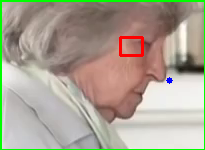

In [345]:
uf.show_frame_in_notebook(crop_frame)

In [319]:
_=cv2.circle(full_frame, (int(gaze_x_frame), int(gaze_y_frame)), radius=3, color=(0, 255, 0), thickness=5)  

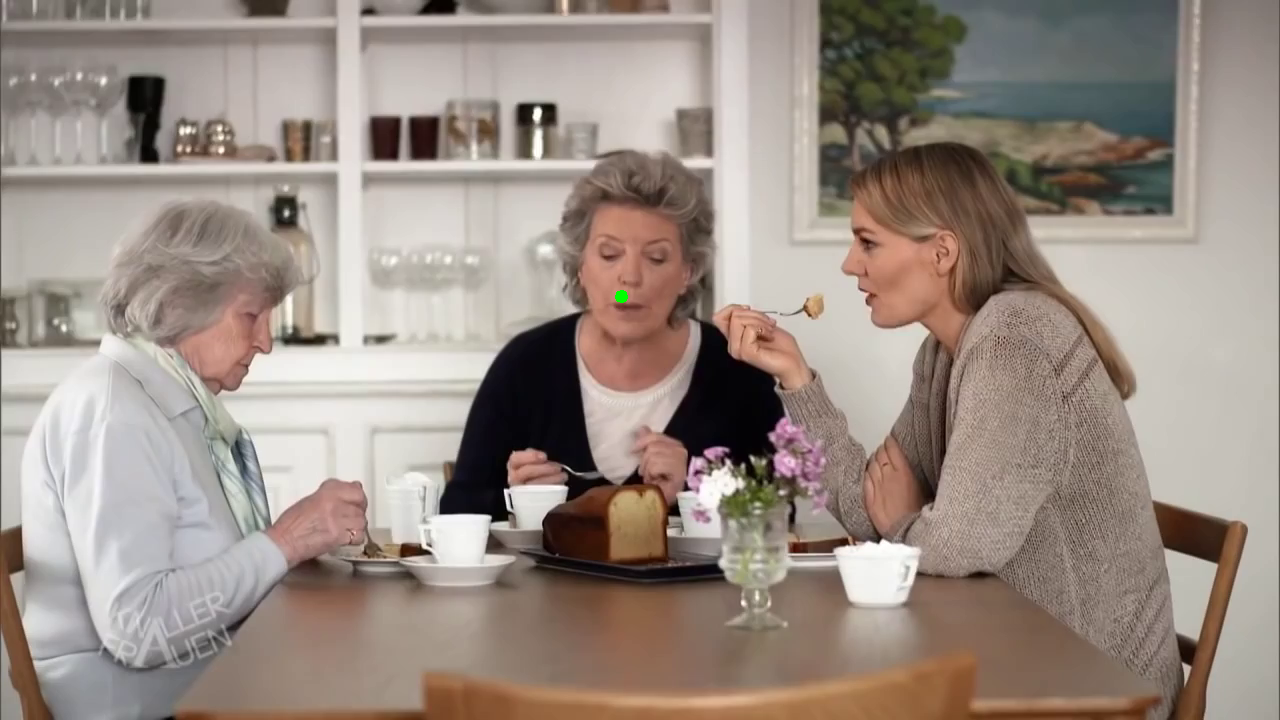

In [320]:
uf.show_frame_in_notebook(full_frame)

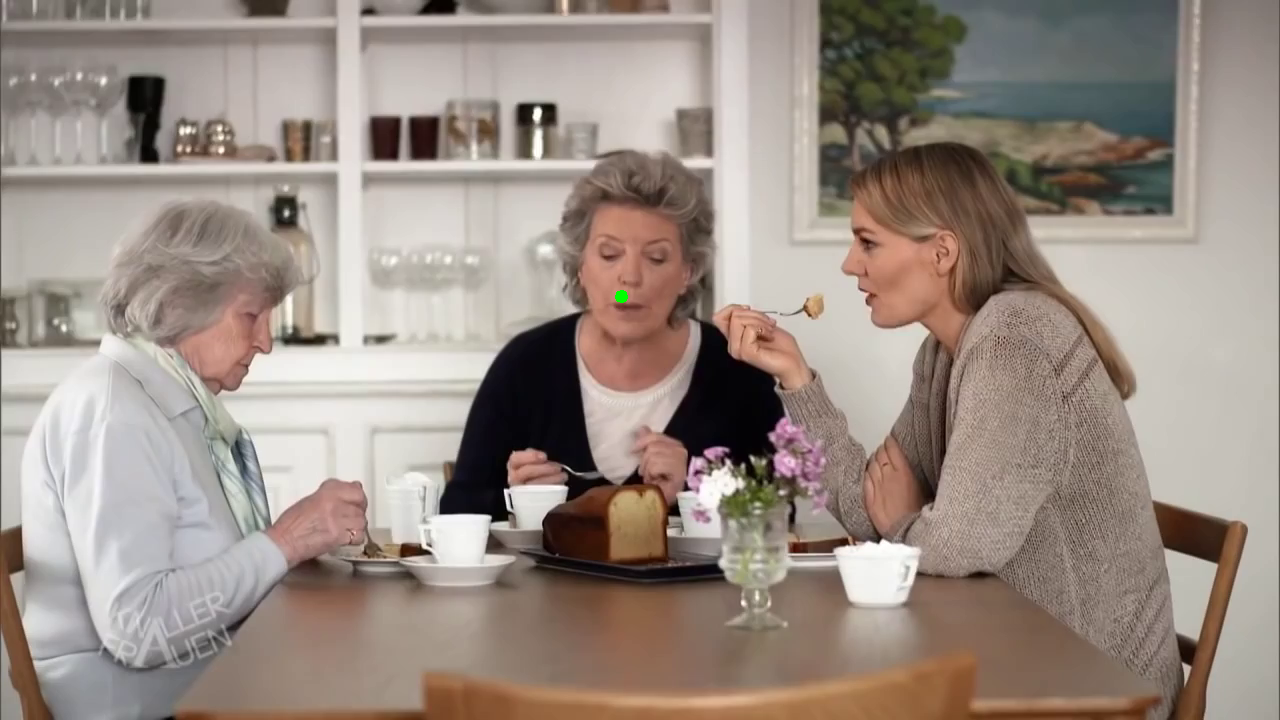

In [321]:
uf.show_frame_in_notebook(full_frame)

## 3) Applicazione modello gaze360 per stima punti di gaze:
GOAL: costruzione json (per video) con relativi info per faccia_id e per frame_id. Le informazioni saranno usate successivamente per costruire mappe salienti eventualmente pesate 

In [5]:
#carico gaze model
gaze_model=load_gazemodel()
#dimensione frame di input al modello
model_input_frame_shape = (224,224)


In [ ]:
#gaze360 model richiede 7 frame dove quello target è il 4° 
WINDOW_FRAME_LEN = 7 
#gaze360 model usa resent come backbone quindi bisogna standardizzare secondo specifici valori
image_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#considerando che il crop è rispetto al viso, allora consideriamo la metà della distanza tra il centro e l'immagine 
gaze_scale_factor= (model_input_frame_shape[0]/2)*0.5
for fm_name in os.listdir(RAW_FACIAL_MARK_PATH):   
    VIDEO_ID = int(re.search(r'\d+', fm_name).group())
    if VIDEO_ID==20 or f'{VIDEO_ID}.json' in os.listdir(GAZE_INPUT_POINT_DATA_PATH):  
        continue
    print('START video id=>',VIDEO_ID)
    custom_facial_mark_data=uf.read_json(path=os.path.join(RAW_FACIAL_MARK_PATH,f'{VIDEO_ID}.json'))
    FRAME_HW_fm = custom_facial_mark_data['FRAME_HW']
    FRAME_CNT_fm=custom_facial_mark_data['FRAME_CNT']
    FACES_CNT_fm = custom_facial_mark_data['FACES_CNT']
    FACIAL_DATA_fm=custom_facial_mark_data['FACIAL_DATA']
    print('***info facial mark data:\n', 'FRAME CNT=>',FRAME_CNT_fm,'FRAME_HW_fm=>',FRAME_HW_fm,'FACES_CNT_fm=>',FACES_CNT_fm)
    custom_gaze_data={
            'VIDEO_ID':VIDEO_ID, 'FRAME_HW': FRAME_HW_fm,
            'FACES_CNT':FACES_CNT_fm,'FRAME_CNT': FRAME_CNT_fm,  
            #contiene come chiave principale il frame e per ogni frame abbiamo le chiavi dei face_id. Per ogni face_id: 1) gaze2dxy 2)gaze3d 3)std. 
            'GAZE_DATA' : {}}
    for frame_id in range(FRAME_CNT_fm):
        if frame_id>0 and frame_id%100==0: 
            print('next frame to process==>',frame_id)
        #ottieni lista indici di frame validi da includere per il frame target "frame_id"
        window_frame_idx_list=uf.get_window_frame_ids(frame_cnt=FRAME_CNT_fm, target_index=frame_id, window_size=WINDOW_FRAME_LEN)
        custom_gaze_data['GAZE_DATA'][frame_id]={}
        #per un dato frame target devo ottenere il crop rispetto ad una singola faccia "face_id"
        for face_id in range(FACES_CNT_fm): 
            custom_gaze_data['GAZE_DATA'][frame_id][face_id]={}
            try:
                #nb: gaze360 richiede 7 frame di input (3 + frame target + 3] x 3 canali x dimensione frame per cnn
                input_image = torch.zeros(7,3,model_input_frame_shape[0],model_input_frame_shape[1])
                target_frame_info={'eyes_middle_full_xy': None, 'face_crop_xy': None,'face_crop_hw':None}
                for context_pos, context_frame_id in enumerate(window_frame_idx_list):
                    #leggo il frame dal quale ritaglierò il viso richiesto 
                    aframe=uf.read_specific_frame(video_path=os.path.join(RAW_VIDEO,str(VIDEO_ID).zfill(3)+'.mp4'),frame_idx=context_frame_id) 
                    #print('aframe shape==>',aframe.shape,'context_pos=>',context_pos,'context_frame_id=>',context_frame_id)
                    #ottento facial landmark rispetto alla coppia (FACE_ID, FRAME_ID)
                    fm_list_wrt_face_frame= FACIAL_DATA_fm[str(face_id)][context_frame_id] 
                    #se ci sono 68 punti ci sono cira 12 punti corrispondenti ad entrambi gli occhi
                    eys_idx_pos=(0,len(fm_list_wrt_face_frame))
                    if len(fm_list_wrt_face_frame)==39:
                        #se ci sono 39 punti 
                        eyes_idx_pos = (5,14) #circa 9 punti 
                    elif  len(fm_list_wrt_face_frame)>39:
                        eyes_idx_pos = (36,48)
    
                    #bounding box occhi 
                    eyes_x,eyes_y, eyes_w,eyes_h = uf.get_face_bounding_box(landmarks=fm_list_wrt_face_frame[eyes_idx_pos[0]:eyes_idx_pos[1]],pad_w_r=0,pad_h_r=0)
                    #centro bb OCCHI 
                    eyes_middle_x = eyes_x + eyes_w/2 
                    eyes_middle_y = eyes_y + eyes_h/2 
                    #bounding box faccia
                    x, y, w, h = uf.get_face_bounding_box(landmarks=fm_list_wrt_face_frame,pad_w_r=0.5,pad_h_r=0.5)
                    x_face_crop, y_face_crop, w_face_crop, h_face_crop= uf.clamp_rect_to_frame(x, y, w, h, frame_shape=FRAME_HW_fm)
                    #salva info relative al frame target
                    if context_pos==3: 
                        target_frame_info['eyes_middle_full_xy']=[eyes_middle_x,eyes_middle_y]
                        target_frame_info['face_crop_xy'] = [x_face_crop,y_face_crop]
                        target_frame_info['face_crop_hw'] = [h_face_crop,w_face_crop]
                    #ritaglia area intorno alla faccia 
                    cropped_frame = aframe[int(y_face_crop):int(y_face_crop+h_face_crop), int(x_face_crop):int(x_face_crop+w_face_crop)]
                    
                    #per convertire in immagine PIL vogliamo RGB and no BGR (default per cv2)
                    rgb_cropped_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
                    #per effettuare il resize bisogna convertire in PIL
                    rgb_pil_frame = Image.fromarray(rgb_cropped_frame,'RGB')
                    #aggiorno input che passerò al modello 
                    input_image[context_pos,:,:,:] = image_normalize(transforms.ToTensor()(transforms.Resize(model_input_frame_shape)(rgb_pil_frame)))
                    #cv2.imwrite(os.path.join(GAZE_MODEL_INPUT_EXAMPLE,f"cropped_video_{VIDEO_ID}_face_{face_id}_frame_{context_frame_id}_pos{context_pos}.png"), cropped)
                
                #APPLICO modello 
                #a0 = time.time()
                output_gaze,output_std = gaze_model(input_image.view(1,7,3,model_input_frame_shape[0],model_input_frame_shape[1]).to(DEVICE))
                #a1 = time.time()
                #print('a1==>',a1-a0)
                #converto risultato in coordinate cartesiane
                gaze_vector_mean = uf.spherical2cartesial(output_gaze).detach().cpu().numpy().reshape(-1)
                if gaze_vector_mean[2]>=0:  
                    print('*** gz not valid for', face_id, 'frame',frame_id,'video=>',VIDEO_ID,'gz=>',gaze_vector_mean[2])
                    continue
                #calcolo origine del gaze nel crop ridimensionato
                #1)origine centro occhi nel crop 
                eyes_middle_y_in_crop = target_frame_info['eyes_middle_full_xy'][1] - target_frame_info['face_crop_xy'][1]
                eyes_middle_x_in_crop = target_frame_info['eyes_middle_full_xy'][0] - target_frame_info['face_crop_xy'][0]
                #2) origine occhi nel crop ridimensionato 
                x_in_crop_resized = eyes_middle_x_in_crop * (model_input_frame_shape[1] / target_frame_info['face_crop_hw'][1])
                y_in_crop_resized = eyes_middle_y_in_crop * (model_input_frame_shape[0] / target_frame_info['face_crop_hw'][0])
                #3) computo punto gaze 2d 
                a2 = time.time()
                gaze_x,gaze_y,fs=uf.estimate_2d_gaze_endpoint(origin=(int(x_in_crop_resized),int(y_in_crop_resized)),face_size=gaze_scale_factor, gaze_vector=gaze_vector_mean, image_shape=model_input_frame_shape,prospective_eq=True, scale_factor=1)
                #a3 = time.time()
                #print('a3==>',a3-a2)
                #campiono angoli 
                angle_id = 0
                angle_x_list=uf.sampling_angles_from_norm(angle=output_gaze.detach().cpu().numpy().reshape(-1)[angle_id],offset=output_std.detach().cpu().numpy().reshape(-1)[angle_id],n_sample=130)
                angle_id = 1
                angle_y_list=uf.sampling_angles_from_norm(angle=output_gaze.detach().cpu().numpy().reshape(-1)[angle_id],offset=output_std.detach().cpu().numpy().reshape(-1)[angle_id],n_sample=130)
                gaze2d_points ={'x':[],'y':[]}
                for angle_x,angle_y in zip(angle_x_list,angle_y_list): 
                    gaze_vector_tmp=uf.spherical2cartesial(torch.FloatTensor([[angle_x,angle_y]])).detach().numpy().reshape(-1)
                    if gaze_vector_tmp[2]>=0: 
                        continue
                    gaze2d_x,gaze2d_y,k=uf.estimate_2d_gaze_endpoint(origin=(int(x_in_crop_resized),int(y_in_crop_resized)), gaze_vector=gaze_vector_tmp,face_size=gaze_scale_factor, image_shape=model_input_frame_shape, prospective_eq=True,scale_factor=1) 
                    gaze2d_points['x'].append(gaze2d_x)
                    gaze2d_points['y'].append(gaze2d_y)
                if len(gaze2d_points)<2:  
                    gaze2d_points['x']+=[gaze_x,gaze_x]  
                    gaze2d_points['y']+=[gaze_y,gaze_y]  
    
                #a4 = time.time()
                #print('a4==>',a4-a3)
                #calcola deviazione per x e anche per y 
                std_x = np.std(gaze2d_points['x'], ddof=1)
                std_y = np.std(gaze2d_points['y'], ddof=1)
                #qui assumo distribuzione isotropica quindi mappa gaussiana simettrica rispetto alla media
                std_gauss_estimated= np.mean([std_x,std_y])
                #mentre qui memorizziamo la matrice di covariaza per modellare gaussiana di forma ellittica e orientata 
                points = np.array(list(zip(gaze2d_points['x'], gaze2d_points['y'])))
                cov_matrix = np.cov(points.T).tolist()
                #infine dobbiamo convertire il punto di gaze e std nel full frame. Poichè è stato fatto resizing bisogna usare fattore di scala
                #converti coordinate in maniera relativa 
                gaze_x_rel = gaze_x/model_input_frame_shape[1]
                gaze_y_rel = gaze_y/model_input_frame_shape[0]
                #converti in maniera assoluta rispetto al frame croppato
                gaze_x_crop = gaze_x_rel*target_frame_info['face_crop_hw'][1] 
                gaze_y_crop = gaze_y_rel*target_frame_info['face_crop_hw'][0]
                #converti in maniera assoluta rispetto al frame intero 
                #coordinate del frame croppato nel frame intero 
                gaze_x_frame = target_frame_info['face_crop_xy'][0] + gaze_x_crop
                gaze_y_frame =target_frame_info['face_crop_xy'][1] + gaze_y_crop
                #riscalo std e matrice di covarianza (calcolo fattore di scala essendo stato fatto ridimensionamento)
                scale_x = target_frame_info['face_crop_hw'][1] / model_input_frame_shape[1]
                scale_y = target_frame_info['face_crop_hw'][0] / model_input_frame_shape[0]
                std_x_frame = std_x*scale_x
                std_y_frame = std_y*scale_y
                std_gauss_estimated_frame= np.mean([std_x_frame,std_y_frame])
                #riscalo matrice di covarianza (nota:varianze si scalano quadraticamente)
                cov_mtx_frame =[
                    [cov_matrix[0][0] * scale_x**2, cov_matrix[0][1] * scale_x * scale_y],
                    [cov_matrix[1][0] * scale_x * scale_y, cov_matrix[1][1] * scale_y**2]
                ]
                #SALVO DATI         
                custom_gaze_data['GAZE_DATA'][frame_id][face_id]['gaze_xy']=[float(gaze_x_frame),float(gaze_y_frame)]
                custom_gaze_data['GAZE_DATA'][frame_id][face_id]['std_isotropic']=float(std_gauss_estimated_frame)
                custom_gaze_data['GAZE_DATA'][frame_id][face_id]['cov_mtx']=cov_mtx_frame
                custom_gaze_data['GAZE_DATA'][frame_id][face_id]['gaze_raw_xyz']=gaze_vector_mean.tolist()
                custom_gaze_data['GAZE_DATA'][frame_id][face_id]['gaze_raw_angles']=output_gaze.detach().cpu().numpy().reshape(-1).tolist()
                custom_gaze_data['GAZE_DATA'][frame_id][face_id]['gaze_raw_offset']=output_std.detach().cpu().numpy().reshape(-1).tolist()
                
            except Exception as e: 
                print('error',e,'for=>','video id=>',VIDEO_ID,'frame target=>',frame_id,'face id=>',face_id)
                continue 
    #salva info come json
    print(f'\nEND VIDEO=>{VIDEO_ID}*****')
    uf.write_json(data=custom_gaze_data,path=os.path.join(GAZE_INPUT_POINT_DATA_PATH,f'{VIDEO_ID}.json'))
    """
    #TESTA finestra 
    if frame_id<WINDOW_FRAME_LEN or frame_id> FRAME_CNT_fm-WINDOW_FRAME_LEN:  
        print('****frame id ==>',frame_id) 
        print('windows frame idx ===>', window_frame_idx_list)
    """

START video id=> 3
***info facial mark data:
 FRAME CNT=> 1440 FRAME_HW_fm=> [720, 1280] FACES_CNT_fm=> 3


/tmp/ipykernel_1268/2584768633.py:69: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  rgb_pil_frame = Image.fromarray(rgb_cropped_frame,'RGB')


*** gz not valid for 2 frame 0 video=> 3 gz=> 0.6037912
*** gz not valid for 2 frame 1 video=> 3 gz=> 0.57123524
*** gz not valid for 2 frame 2 video=> 3 gz=> 0.5298565
*** gz not valid for 2 frame 3 video=> 3 gz=> 0.50272554
*** gz not valid for 2 frame 4 video=> 3 gz=> 0.4911123
*** gz not valid for 2 frame 5 video=> 3 gz=> 0.5002508
*** gz not valid for 2 frame 6 video=> 3 gz=> 0.52432334
*** gz not valid for 2 frame 7 video=> 3 gz=> 0.5403363
*** gz not valid for 2 frame 8 video=> 3 gz=> 0.5443992
*** gz not valid for 2 frame 9 video=> 3 gz=> 0.5439965
*** gz not valid for 2 frame 10 video=> 3 gz=> 0.5367602
*** gz not valid for 2 frame 11 video=> 3 gz=> 0.5192825
*** gz not valid for 2 frame 12 video=> 3 gz=> 0.50485235
*** gz not valid for 2 frame 13 video=> 3 gz=> 0.49441513
*** gz not valid for 2 frame 14 video=> 3 gz=> 0.48577613
*** gz not valid for 2 frame 15 video=> 3 gz=> 0.48803645
*** gz not valid for 2 frame 16 video=> 3 gz=> 0.50942945
*** gz not valid for 2 frame 17 v

In [ ]:
print('done')

## 4) Costruzione mappe di salienza come input
    note: avremo due tipi di mappe:  1) gaussiane con distribuzione isotropica (1sigma) 2) gaussiane con mtrx di covarianza e covarianze non nulle

In [6]:
len(os.listdir(GAZE_INPUT_POINT_DATA_PATH))

65

In [ ]:
for gaze_data_name in os.listdir(GAZE_INPUT_POINT_DATA_PATH): 
    print('CHECK=>',gaze_data_name)
    if not gaze_data_name.endswith('.json') or gaze_data_name.replace('.json','') in os.listdir(GAUSSIAN_COV_INPUT_DATA_PATH):
        continue
    print('to do=>',gaze_data_name)
    VIDEO_ID = gaze_data_name.split('.')[0]
    gaze_js_data=uf.read_json(path=os.path.join(GAZE_INPUT_POINT_DATA_PATH,gaze_data_name))
    FRAME_SHAPE = tuple(gaze_js_data['FRAME_HW'])
    FRAME_CNT=gaze_js_data['FRAME_CNT'] 
    #scaliamo del 2,5% rispetto all'altezza come visto in alcuni paper
    SCALE_STD_FACTOR = FRAME_SHAPE[0]*0.025
    for frame_idx in range(FRAME_CNT):  
        try:
            x_list=[]
            y_list=[]
            std_iso_list=[]
            cov_list = []
            std_iso_list_k=[]
            cov_list_k = []
            for face_id in range(gaze_js_data['FACES_CNT']):
                gaze_data=gaze_js_data['GAZE_DATA'].get(str(frame_idx),{}).get(str(face_id),{}) 
                if not gaze_data:
                    continue
                #print('***************frame',frame_idx,'face-id',face_id)
                x =float(gaze_data['gaze_xy'][0])
                y =float(gaze_data['gaze_xy'][1])
                std_isotropic=float(gaze_data['std_isotropic'])
                #print('X AND Y===>', x,y)
                cov_mtx= gaze_data['cov_mtx']
                #print('cov mtz==>',cov_mtx)
                x_list.append(x) 
                y_list.append(y) 
                
                std_iso_list.append(std_isotropic)
                #print('std isotropic=>',std_isotropic*SCALE_STD_FACTOR)
                std_iso_list_k.append(std_isotropic*SCALE_STD_FACTOR)
                cov_list.append(cov_mtx)
                cov_list_k.append((np.array(cov_mtx)*SCALE_STD_FACTOR*SCALE_STD_FACTOR).tolist())
                #print('cov =>',(np.array(cov_mtx)*SCALE_STD_FACTOR*SCALE_STD_FACTOR).tolist())
            #crea le mappe 
            gaussian_iso_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]), sigma_in=std_iso_list, weight_in=None)
            gaussian_cov_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]), sigma_in=cov_list, weight_in=None)
            gaussian_iso_k_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]), sigma_in=std_iso_list_k, weight_in=None)
            gaussian_cov_k_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]), sigma_in=cov_list_k, weight_in=None)
            #nome mappa
            map_file_name=f'video{VIDEO_ID}_frame{frame_idx}.png'
            #esporta ogni mappa 
            #crate folder wrt the video per each target path 
            for target_path in [GAUSSIAN_ISO_INPUT_DATA_PATH,GAUSSIAN_COV_INPUT_DATA_PATH,GAUSSIAN_ISOk_INPUT_DATA_PATH,GAUSSIAN_COVk_INPUT_DATA_PATH]:
                dest_folder = os.path.join(target_path,f"{VIDEO_ID}")
                os.makedirs(dest_folder, exist_ok=True)
            uf.export_mask2image(my_mask=gaussian_iso_map,path=os.path.join(GAUSSIAN_ISO_INPUT_DATA_PATH,f"{VIDEO_ID}",map_file_name))
            uf.export_mask2image(my_mask=gaussian_cov_map,path=os.path.join(GAUSSIAN_COV_INPUT_DATA_PATH,f"{VIDEO_ID}",map_file_name))
            uf.export_mask2image(my_mask=gaussian_iso_k_map,path=os.path.join(GAUSSIAN_ISOk_INPUT_DATA_PATH,f"{VIDEO_ID}",map_file_name))
            uf.export_mask2image(my_mask=gaussian_cov_k_map,path=os.path.join(GAUSSIAN_COVk_INPUT_DATA_PATH,f"{VIDEO_ID}",map_file_name))
        except Exception as e: 
            print('errore',e,'with video',VIDEO_ID,'at frame',frame_idx)
            continue

CHECK=> .ipynb_checkpoints
CHECK=> 3.json
to do=> 3.json


In [10]:
print('done')

done


In [14]:
print('done29')

done29
